# **Is It Cat or Dog?**

In this project, we aim to classify images of cats and dogs using a Convolutional Neural Network (CNN) model. Leveraging the ["Dogs vs Cats" dataset from Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats/overview), we will explore various stages of machine learning development, including data preprocessing, visualization, and modeling.

### Workflow Overview:
1. **Data Preprocessing**: Prepare the dataset for analysis and model training by utilizing `ImageDataGenerator` for efficient augmentation and scaling.
2. **Exploratory Data Analysis**: Visualize key aspects of the image data to gain insights and validate preprocessing steps.
3. **Model Development**: Build and train a deep learning CNN architecture to distinguish between cat and dog images with high accuracy.

<div style="text-align: center;">
    <img src="https://images.pexels.com/photos/1909802/pexels-photo-1909802.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" alt="Image">
</div>

# Importing packages

In [1]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import tensorflow as tf
import zipfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

2025-04-12 15:44:25.889604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744472666.170148      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744472666.254734      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing and preprocessing dataset

In [2]:
#extracting the ZIP file
zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
extract_dir = '/kaggle/working/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
#creating class folders
dataset_dir = '/kaggle/working/train/'
output_dir = '/kaggle/working/train'

os.makedirs(os.path.join(output_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'dog'), exist_ok=True)

for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'): 
        if 'cat' in filename.lower():
            shutil.move(os.path.join(dataset_dir, filename), os.path.join(output_dir, 'cat', filename))
        elif 'dog' in filename.lower():
            shutil.move(os.path.join(dataset_dir, filename), os.path.join(output_dir, 'dog', filename))

In [4]:
#defining the dataset folder path after extraction
dataset_dir = os.path.join('/kaggle/working/train')

#creating ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#training
train_generator = train_datagen.flow_from_directory(dataset_dir,target_size=(224, 224),
    batch_size=256,class_mode='binary',subset='training')

#validation
validation_generator = train_datagen.flow_from_directory(dataset_dir,target_size=(224, 224),
    batch_size=256,class_mode='binary',subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Exploratory Data Analysis - EDA

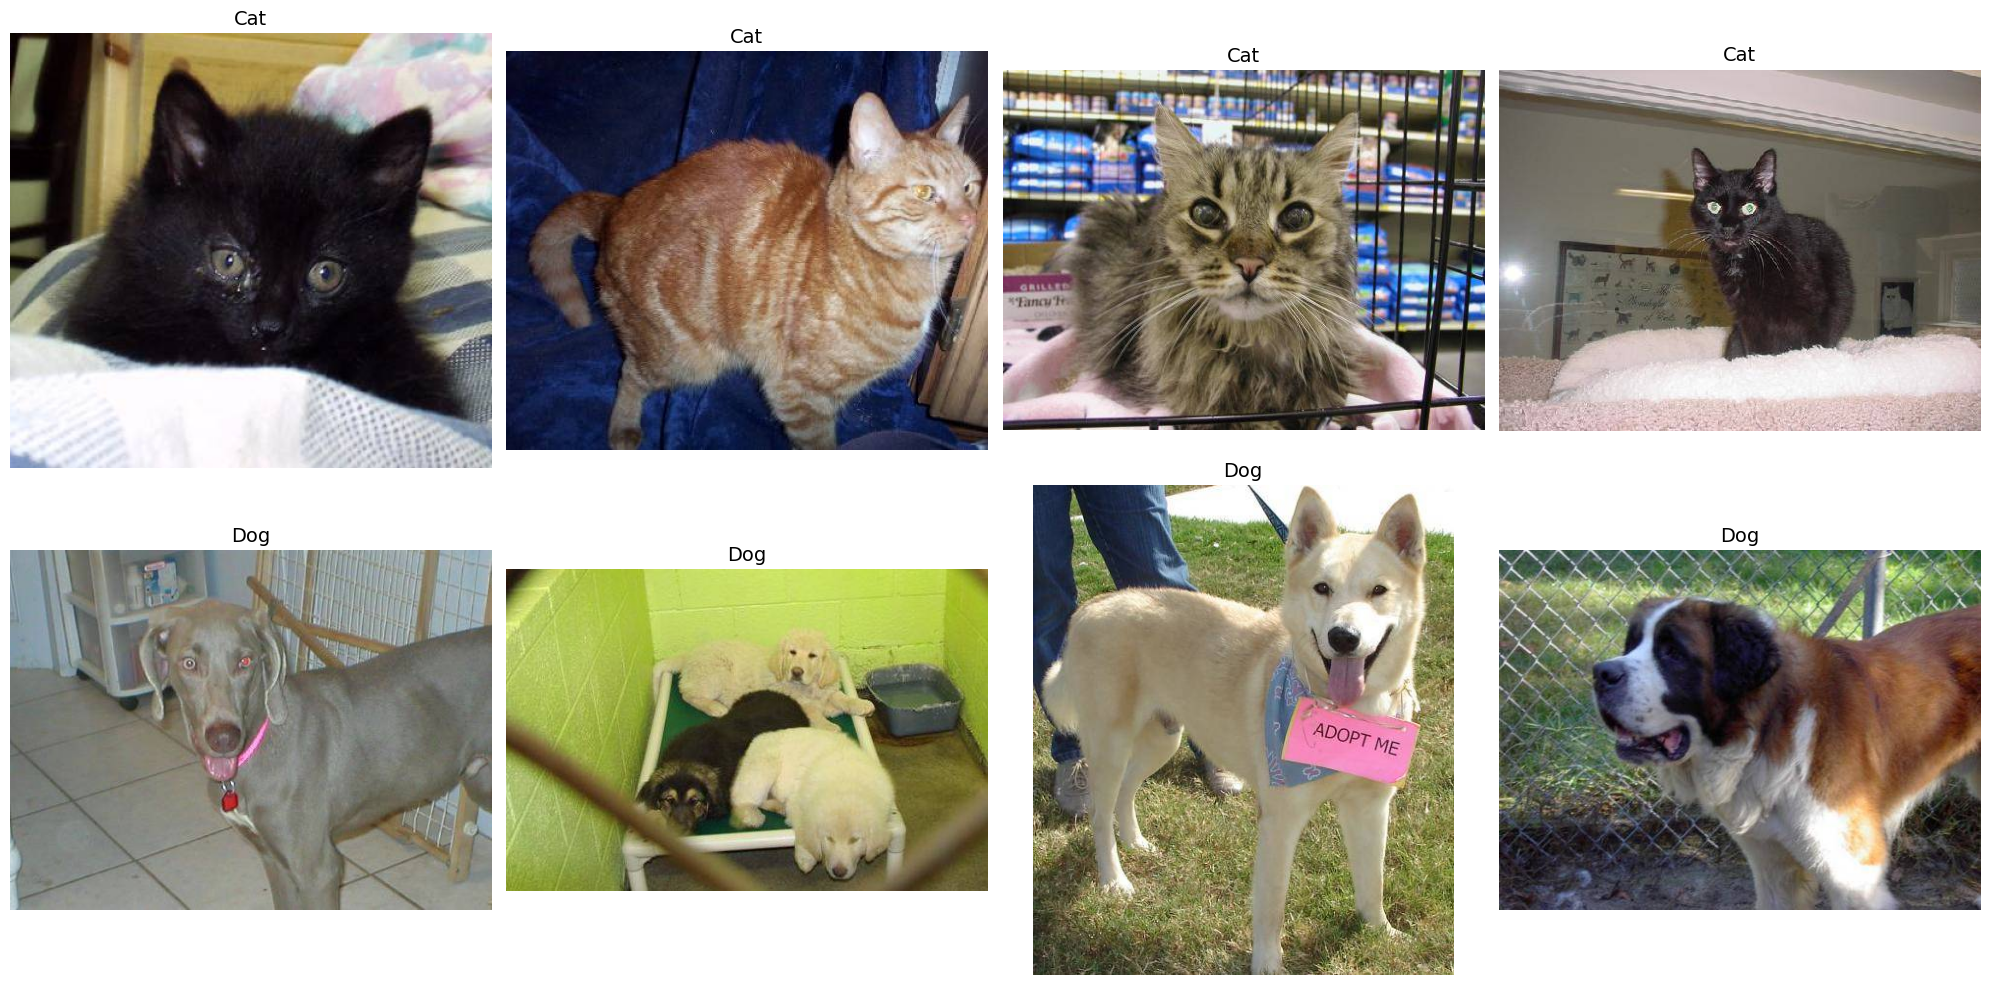

In [5]:
#displaying 4 images for each class
cat_images = []
dog_images = []

for filename, label in zip(train_generator.filenames, train_generator.labels):
    img_path = os.path.join(train_generator.directory, filename)
    if label == 0:
        cat_images.append(img_path)
    elif label == 1:
        dog_images.append(img_path)
    if len(cat_images) >= 4 and len(dog_images) >= 4:
        break

images_to_display = cat_images[:4] + dog_images[:4]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    img = image.load_img(images_to_display[i])
    ax.imshow(img)
    ax.axis('off')
    if i < 4:
        ax.set_title("Cat", fontsize=14)
    else:
        ax.set_title("Dog", fontsize=14)
plt.tight_layout()
plt.show()

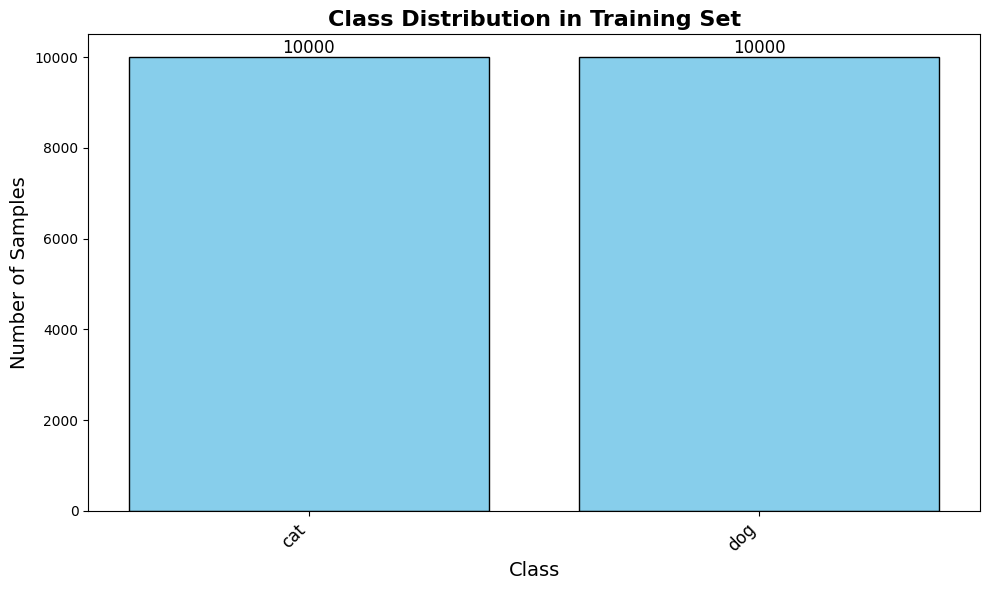

In [6]:
#class distribution
class_labels = list(train_generator.class_indices.keys())
train_class_counts = [list(train_generator.labels).count(i) for i in range(len(class_labels))]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, train_class_counts, color='skyblue', edgecolor='black')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, 
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=12)
plt.title('Class Distribution in Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# Deep Learning Modelling

In [7]:
#defining and training the custom CNN model
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(70, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

custom_cnn_model = cnn_model() 
history=custom_cnn_model.fit(train_generator, validation_data=validation_generator, epochs=5, verbose=0)

2025-04-12 15:44:57.986764: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
#making predictions on some sample data
sample_images, sample_labels = next(validation_generator) 
predictions = custom_cnn_model.predict(sample_images)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step


In [9]:
custom_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 70)                  │      13,063,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,249,641 (149.73 MB)

 Trainable params: 13,083,213 (49.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,166,428 (99.82 MB)

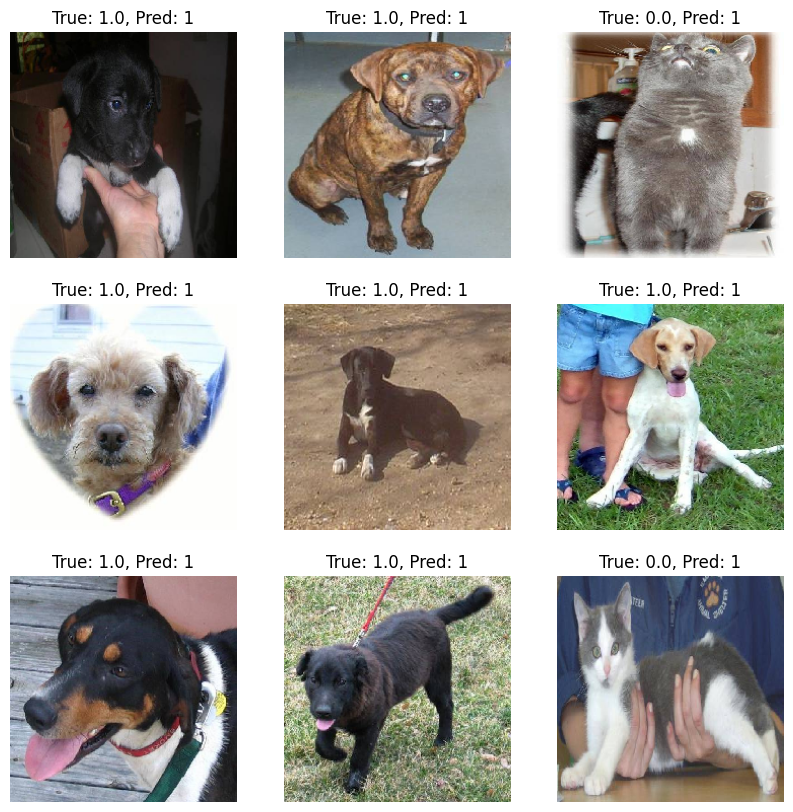

In [10]:
#displaying sample images and their predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f'True: {sample_labels[i]}, Pred: {predicted_labels[i]}')
    plt.axis('off')
plt.show()

In [11]:
#classification report
y_true_classes = sample_labels
y_pred_classes = predicted_labels
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.72      0.78       124
         1.0       0.77      0.88      0.82       132

    accuracy                           0.80       256
   macro avg       0.81      0.80      0.80       256
weighted avg       0.81      0.80      0.80       256



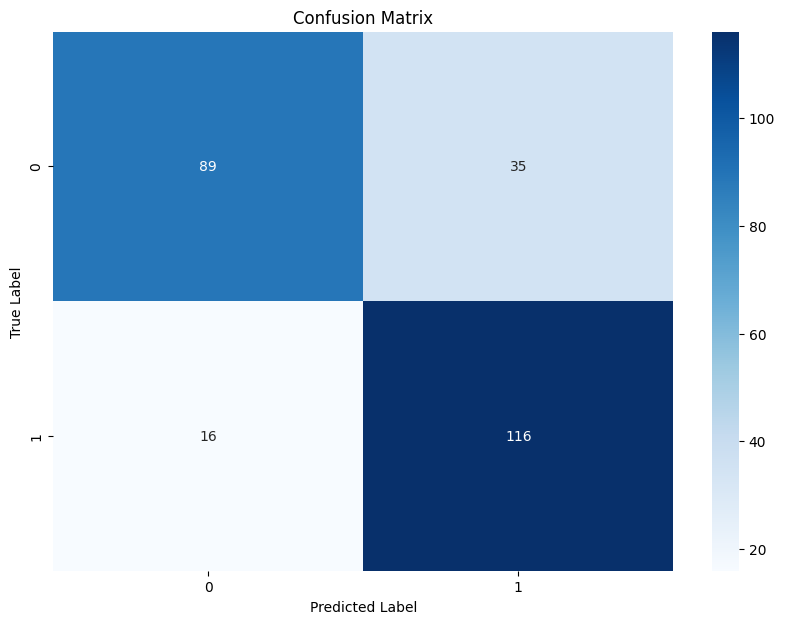

In [12]:
#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

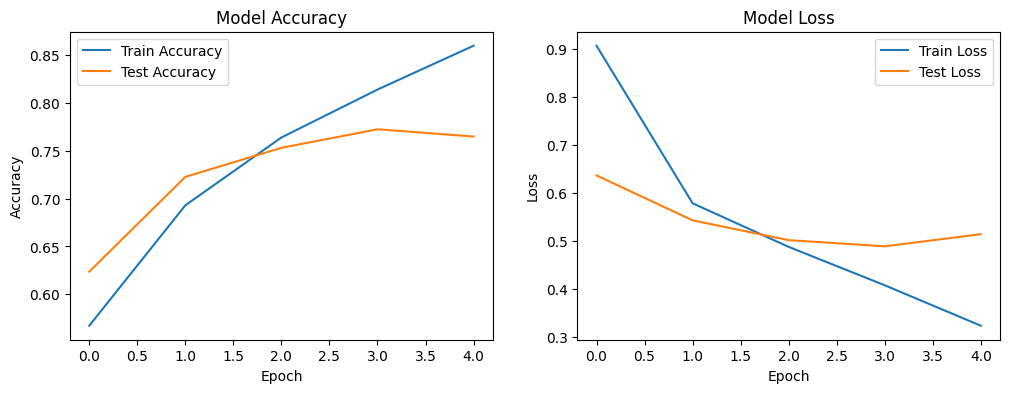

In [13]:
#accuracy and loss graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# **Conclusion**

In this project, we successfully classified images of cats and dogs using a **Convolutional Neural Network (CNN)**, achieving an accuracy of **0.80** on the validation set. This result reflects the capability of deep learning techniques to handle binary image classification effectively.

### Key Accomplishments
- Designed and trained a CNN model to differentiate between cats and dogs.
- Incorporated **data augmentation** to improve the model’s generalization and robustness.
- Achieved strong performance on a balanced dataset by leveraging careful preprocessing and effective architecture.

### Future Directions
To push the accuracy beyond 0.80, we can:
- **Explore Transfer Learning**: Use pre-trained models like **ResNet50** or **EfficientNet** for improved feature extraction.
- **Fine-Tune Hyperparameters**: Experiment with optimizers, learning rates, and other parameters to refine the model.